# Example Model and Creating Capstone Utils

The goal of this workbook is to model for one ticker with the data from the create_ticker_df function I made in 1_Data_Collection_And_EDA.ipynb.

I will start with modeling for PTON, and then generalize that code into functions saved in capstone_utils.py. Collect_Data_and_Model_Ticker.ipynb will use those generalized functions to collect data and model for any ticker.

---

# Modeling to Predict Changes in Peloton Stock (PTON)

PTON was first stock to make me interested in using Google Trends to predict stock price changes. Search interest for 'PTON' was at an all-time high in September 2020, and in the months following the value of the stock doubled in value. This is why I am going to model for PTON first. My hypothesis is that using Google Trends will improve my model's ability to accurately predict the rise of Peloton in 2020.

In [45]:
#Imports
from alpha_vantage.timeseries import TimeSeries
import requests
import pandas as pd
import pandas as pd                        
from pytrends.request import TrendReq
from IPython.display import Image
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
from datetime import datetime
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
# We are required to do this in order to avoid "FutureWarning" issues.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR

In [46]:
#see 1_Data_Collection_And_EDA.ipynb for how I created these functions
def spdr_adj_close():
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=spy&apikey=49KFJCFS3P6CEU4F&outputsize=full'
    r = requests.get(url)
    data = r.json()
    df = pd.DataFrame(data['Time Series (Daily)']).T
    df['date'] = df.index
    df.index = pd.to_datetime(df['date'])
    df = df[df['date'] > '2018-01-01']
    df = df[df['date'] < '2021-06-02']
    df.drop(columns = 'date', inplace = True)
    df.sort_index(inplace=True)
    return df['5. adjusted close']

def create_ticker_df (ticker):
    '''Returns a DataFrame of stock and Google Trends data for the given ticker. The output will be daily data 1/2/18-6/1/21'''
    #collect stock data using Alpha Vantage API
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={ticker}&apikey=49KFJCFS3P6CEU4F&outputsize=full'
    r = requests.get(url)
    data = r.json()
    df = pd.DataFrame(data['Time Series (Daily)']).T
    
    #filter to include 2018.01.02 - 2021.06.01
    df['date'] = df.index
    df.index = pd.to_datetime(df['date'])
    df = df[df['date'] > '2018-01-01']
    df = df[df['date'] < '2021-06-02']
    df.drop(columns = 'date', inplace = True)
    df.sort_index(inplace=True)
    
    #add lag columns
    days_to_lag = [1,2,3,7,30,90,365]
    for day in days_to_lag:
        df[f'lag_{day}'] = df['5. adjusted close'].shift(day)
    
    #fix dtypes and column names
    df['spdr_adj_close'] = spdr_adj_close()
   
    
    for col in df.columns:
        df[col] = pd.to_numeric(df[col])
    df['daily_returns'] = df['5. adjusted close'] - df['lag_1']
    df['daily_pct_return'] = df['daily_returns']/df['5. adjusted close'].shift(1)
    df['rolling_3d_adj_close'] = df['5. adjusted close'].rolling(3).mean()
    df.rename(columns = {'1. open': 'open',
                        '2. high': 'high',
                        '3. low': 'low',
                        '4. close': 'close',
                        '5. adjusted close': 'adjusted_close',
                        '6. volume': 'volume',
                        '7. dividend amount': 'dividend amount',
                        '8. split coefficient': 'splitcoef',
                        'daily_returns' : 'daily_returns'}, inplace = True)
        
    #Collect Google Trends data using pytrends api
    pytrend = TrendReq()
    pytrend.build_payload(kw_list=[ticker])
    google = pytrend.interest_over_time()
    trends = google[ticker].resample('D', convention = 'start').pad()
    trends = pd.DataFrame(trends)
    trends.rename(columns = {ticker:'trend_score'}, inplace = True)
    
    #merge stock data with trends data
    df = df.merge(trends, how = 'left', left_index = True, right_index = True)
    
    return df

In [47]:
pton = create_ticker_df('PTON')

# Baseline Model: ARIMA

In [48]:
# Create train-test split.
y_train = pton[pton.index < datetime(year = 2021, month = 3, day = 1)]
y_test = pton[pton.index > datetime(year = 2021, month = 3, day = 1)]
y_train = y_train['daily_pct_return']
y_test = y_test['daily_pct_return'] 
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
y_train.dropna(inplace = True)
y_test.dropna(inplace = True)

In [49]:
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [50]:
# Run ADF test on original (non-differenced!) data.
interpret_dftest(adfuller(y_train))

Test Statistic   -1.861373e+01
p-value           2.064081e-30
dtype: float64

Since our p-value is approaching zero that means that our daily_pct_return data is stationary and we are permitted to use an ARIMA model. It makes sense that the daily_pct_return data is stationary considering it's already differenced. The adjusted_close data is not stationary, there has been a lot of movement in the stock price since it's IPO in 2019.

In [51]:
# Starting AIC, p, and q.
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0

# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for q in range(5):
        
        # Insert try and except statements.
        try:
            
            # Fitting an ARIMA(p, 1, q) model.
            print(f'Attempting to fit ARIMA({p},1,{q})')
            
            # Instantiate ARIMA model.
            arima = ARIMA(endog = y_train.astype(float).dropna(), # endog = Y variable
                          order = (p,1,q)) # values of p, d, q
            
            # Fit ARIMA model.
            model = arima.fit()

            # Print out AIC for ARIMA(p, 1, q) model.
            print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')

            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic:
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q = q

        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting to fit ARIMA(0,1,0)
The AIC for ARIMA(0,1,0) is: -934.0440909911908
Attempting to fit ARIMA(0,1,1)
The AIC for ARIMA(0,1,1) is: -1168.7877074340872
Attempting to fit ARIMA(0,1,2)
The AIC for ARIMA(0,1,2) is: -1166.8521823487522
Attempting to fit ARIMA(0,1,3)
The AIC for ARIMA(0,1,3) is: -1165.454779190161
Attempting to fit ARIMA(0,1,4)
The AIC for ARIMA(0,1,4) is: -1163.590455447542
Attempting to fit ARIMA(1,1,0)
The AIC for ARIMA(1,1,0) is: -1021.8127839383114
Attempting to fit ARIMA(1,1,1)
The AIC for ARIMA(1,1,1) is: -1166.8470012794514
Attempting to fit ARIMA(1,1,2)
The AIC for ARIMA(1,1,2) is: -1166.099094316111
Attempting to fit ARIMA(1,1,3)
The AIC for ARIMA(1,1,3) is: -1164.441965703711
Attempting to fit ARIMA(1,1,4)
The AIC for ARIMA(1,1,4) is: -1164.5767382357744
Attempting to fit ARIMA(2,1,0)
The AIC for ARIMA(2,1,0) is: -1063.693551571017
Attempting to fit ARIMA(2,1,1)
The AIC for ARIMA(2,1,1) is: -1165.4277454320309
Attempting to fit ARIMA(2,1,2)
The AIC for ARI

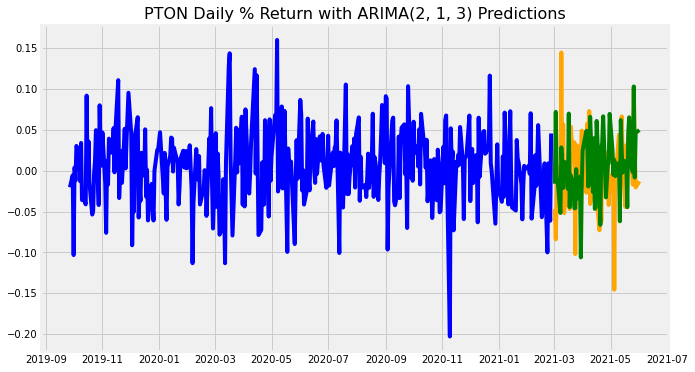

In [52]:
# Instantiate best model.
model = ARIMA(endog = y_train.astype(float).dropna(), # endog = Y variable
              order = (2,1,3))

# Fit ARIMA model.
arima = model.fit()

# Generate predictions based on test set.
preds = model.predict(params = arima.params)
preds= preds[292:]

# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green')

plt.title(label = 'PTON Daily % Return with ARIMA(2, 1, 3) Predictions', fontsize=16)
plt.show();

In [53]:
start =pton.iloc[-65]['adjusted_close']
def make_predicted_adj_close_df(start_adj_close, preds):
    mylist = []
    #mylist = [start_adj_close]
    for day in preds:
        try:
            mylist.append(mylist[-1]*(1+day))
        except:
            mylist.append(start_adj_close)
    return mylist

In [54]:
predicted_adj_close = make_predicted_adj_close_df(start, preds)

In [55]:
#set up index and train_test_split for closing amounts
close_train = pton[pton.index < datetime(year = 2021, month = 3, day = 1)]
close_test = pton[pton.index > datetime(year = 2021, month = 3, day = 1)]
close_train = close_train['adjusted_close']
close_test = close_test['adjusted_close'] 
close_train = pd.DataFrame(close_train)
close_test = pd.DataFrame(close_test)

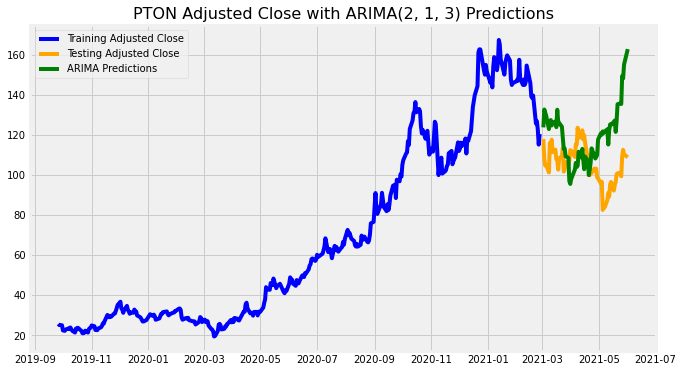

In [56]:
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(close_train.index, pd.DataFrame(close_train), color = 'blue', label = 'Training Adjusted Close')
# Plot testing data.
plt.plot(close_test.index, pd.DataFrame(close_test), color = 'orange', label = 'Testing Adjusted Close')
# Plot predicted test values.
plt.plot(close_test.index, predicted_adj_close, color = 'green', label = 'ARIMA Predictions')

plt.legend()
plt.title(label = 'PTON Adjusted Close with ARIMA(2, 1, 3) Predictions', fontsize=16)
plt.show();

The Blue and yellow lines above are the actual PTON adjusted close amounts. The green line is the ARIMA predictions. As we can see the green line is not close to what actually happened. For a baseline model, however, this is a fine start.


The next step will be to see if we can improve upon this by incorporating Google Trends data.



# ARIMA Model with Exogeneous Predictors

In [57]:
gt_train = pton[pton.index < datetime(year = 2021, month = 3, day = 1)]
gt_train['diff_trend_score']= gt_train['trend_score'].diff(1)
gt_train = gt_train['diff_trend_score']

endog = y_train.astype(float).dropna()
exog = sm.add_constant(gt_train.astype(float).dropna())

In [58]:
mod = sm.tsa.statespace.SARIMAX(endog, exog, order=(2,1,3), trend = 't')
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:       daily_pct_return   No. Observations:                  357
Model:               SARIMAX(2, 1, 3)   Log Likelihood                 580.640
Date:                Mon, 19 Jul 2021   AIC                          -1143.281
Time:                        14:34:41   BIC                          -1108.406
Sample:                             0   HQIC                         -1129.408
                                - 357                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
drift            -3.752e-06   5.65e-06     -0.664      0.507   -1.48e-05    7.33e-06
const             2.049e-32   9.56e-09   2.14e-24      1.000   -1.87e-08    1.87e-08
diff_trend_score  1.632e-05 

In [59]:
preds_with_gt = res.predict()
preds_with_gt = preds_with_gt[292:]

In [60]:
preds_with_gt

date
2020-11-23   -0.000538
2020-11-24   -0.000709
2020-11-25   -0.008355
2020-11-27   -0.003256
2020-11-30   -0.002920
                ...   
2021-02-22   -0.008969
2021-02-23   -0.020647
2021-02-24   -0.014147
2021-02-25   -0.018926
2021-02-26   -0.024197
Name: predicted_mean, Length: 65, dtype: float64

In [61]:
predicted_adj_close = make_predicted_adj_close_df(start, preds_with_gt)
predicted_adj_close = predicted_adj_close[1:]

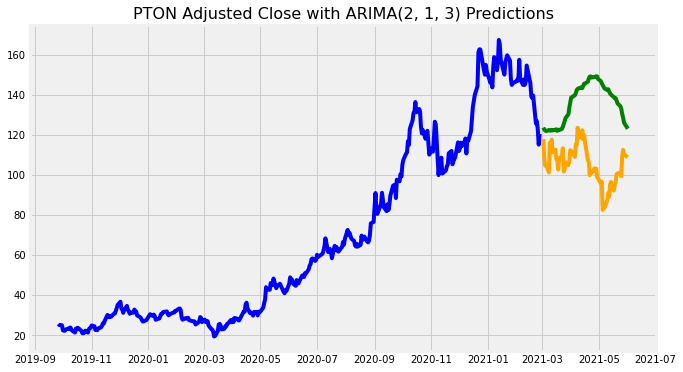

In [62]:
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(close_train.index, pd.DataFrame(close_train), color = 'blue')

# Plot testing data.
plt.plot(close_test.index, pd.DataFrame(close_test), color = 'orange')

# Plot predicted test values.
plt.plot(close_test.index, predicted_adj_close, color = 'green')

plt.title(label = 'PTON Adjusted Close with ARIMA(2, 1, 3) Predictions', fontsize=16)
plt.show();

This ARIMAX model is looking worse than my simple ARIMA model. Both of them do not fit the testing data well, but at least the ARIMA model chart looked like more of a realistic prediction than the ARIMAX.

I don't really want to get too deep into interpreting results until I've run these models on more tickers. But my expectation is that my third model, a VAR model, will be the best since VAR is good for modeling using multiple time series. Since both my stock data and trend data are time series VAR should be the best fit for my purposes.

# Vector Autoregression (VAR) Modeling

This VAR section is highly influenced by the article "Vector Autoregression (VAR) – Comprehensive Guide with Examples in Python" by Selva Prabhakaran of Machine Learning +. The article can be found at https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

A VAR model is implemented when mutiple time series influence each other. If PTON's stock price influences it's trend score, and vice versa, then it is fair to use a VAR model. 

The easiest way to check that time series have an influence on each other is to use Greanger's Causality test. It tests the hypothesis that the past values of time series 1 do not influence the current values of time series 2. If that hypothesis can be rejected then it is fair to say that the time series have an influencing relationship.

In [63]:
#This function is taken from Selva Prabhakaran of MachineLearningPlus.com (https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/)
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(pton, variables = ['adjusted_close', 'trend_score'])

,adjusted_close_x,trend_score_x
adjusted_close_y,1.0000,0.0239
trend_score_y,0.0155,1.0000


Using a p-value of 5%, this test can reject the hpyothesis that adjusted_close and trend_score do not have an influence on each other. Both .0374 and .0046 are less than .05.

In [64]:
#This function is taken from Selva Prabhakaran of MachineLearningPlus.com (https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/)

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(pton[['adjusted_close', 'trend_score']])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
adjusted_close ::  20.8      > 12.3212   =>   True
trend_score ::  0.12      > 4.1296    =>   False


In [65]:
pton['trend_score_diff'] = pton['trend_score'].diff(1)

In [66]:
pton = pton[['adjusted_close', 'trend_score']]

In [67]:
#train_test_split
nobs = 10
pton_train, pton_test = pton[0:-nobs], pton[-nobs:]

In [68]:
pton_differenced = pton_train.diff().dropna()

In [69]:
pton_differenced

,adjusted_close,trend_score
date,,
2019-09-27,-0.52,0.0
2019-09-30,-0.14,-17.0
2019-10-01,-2.59,0.0
2019-10-02,0.09,0.0
2019-10-03,-0.27,0.0
...,...,...
2021-05-11,3.52,0.0
2021-05-12,-1.66,0.0
2021-05-13,5.94,0.0


In [70]:
model = VAR(pton_differenced)

In [71]:
for i in [1,2,3,4,5,6,7,8,9]:
    print(i)
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    #print('BIC : ', result.bic)
    #print('FPE : ', result.fpe)
    #print('HQIC: ', result.hqic, '\n')

1
Lag Order = 1
AIC :  6.398228132909342
2
Lag Order = 2
AIC :  6.398071220910433
3
Lag Order = 3
AIC :  6.417549566545789
4
Lag Order = 4
AIC :  6.379567299974205
5
Lag Order = 5
AIC :  6.389379279837862
6
Lag Order = 6
AIC :  6.378884951011943
7
Lag Order = 7
AIC :  6.374959502679133
8
Lag Order = 8
AIC :  6.3872603914379065
9
Lag Order = 9
AIC :  6.367232390745096


Of these options I select the model with the lowest AIC. For this ticker it is Lag Order 4, with an AIC of -2.4089. I will remake the model using the optimal lag order of 4.

In [72]:
var = model.fit(4)

In [73]:
var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 19, Jul, 2021
Time:                     14:34:41
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    6.55653
Nobs:                     408.000    HQIC:                   6.44959
Log likelihood:          -2441.29    FPE:                    589.681
AIC:                      6.37957    Det(Omega_mle):         564.502
--------------------------------------------------------------------
Results for equation adjusted_close
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.179872         0.190197            0.946           0.344
L1.adjusted_close        -0.070507         0.049498           -1.424           0.154
L1.trend_score            0.042645 

In [74]:
lag_order = var.k_ar

In [75]:
print(lag_order)

4


In [76]:
forecast_input = pton_differenced.values[-lag_order:]

In [77]:
forecast_input

array([[-1.66,  0.  ],
       [ 5.94,  0.  ],
       [ 1.29,  0.  ],
       [-4.29, -6.  ]])

In [78]:
fc = var.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=pton_test.index[-nobs:], columns=pton_train.columns + '_2d')
df_forecast

,adjusted_close_2d,trend_score_2d
date,,
2021-05-18,-0.108845,0.081571
2021-05-19,0.943081,0.240738
2021-05-20,0.366705,-0.490592
2021-05-21,0.237782,1.303015
2021-05-24,0.167576,0.085840
2021-05-25,0.195549,-0.106677
2021-05-26,0.210267,0.091091
2021-05-27,0.065541,-0.245029
2021-05-28,0.155752,-0.037505


In [79]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [80]:
df_results = invert_transformation(pton_train, df_forecast, second_diff=True)
df_results

,adjusted_close_2d,trend_score_2d,adjusted_close_1d,adjusted_close_forecast,trend_score_1d,trend_score_forecast
date,,,,,,
2021-05-18,-0.108845,0.081571,-4.398845,87.891155,-5.918429,16.081571
2021-05-19,0.943081,0.240738,-3.455764,84.435391,-5.677691,10.403881
2021-05-20,0.366705,-0.490592,-3.089059,81.346332,-6.168283,4.235598
2021-05-21,0.237782,1.303015,-2.851277,78.495055,-4.865267,-0.629669
2021-05-24,0.167576,0.085840,-2.683701,75.811354,-4.779427,-5.409096
2021-05-25,0.195549,-0.106677,-2.488152,73.323202,-4.886104,-10.295200
2021-05-26,0.210267,0.091091,-2.277885,71.045317,-4.795013,-15.090214
2021-05-27,0.065541,-0.245029,-2.212344,68.832972,-5.040042,-20.130256
2021-05-28,0.155752,-0.037505,-2.056593,66.776379,-5.077548,-25.207803


In [81]:
predicted_adj_close = df_results[['adjusted_close_forecast', 'trend_score_forecast']]

In [82]:
close_test = pton_test[pton_test.index > datetime(year = 2021, month = 3, day = 1)]

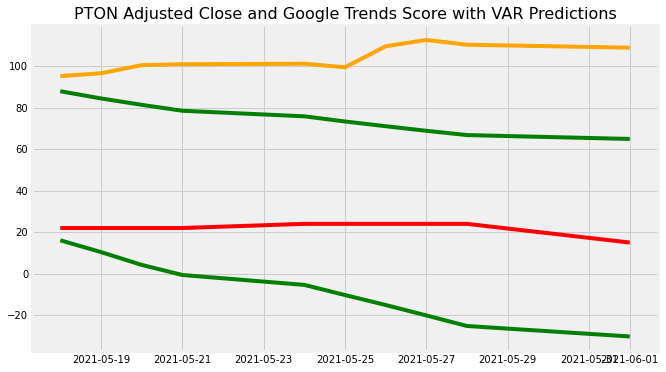

In [83]:
plt.figure(figsize=(10,6))

# Plot testing data.
plt.plot(close_test.index, pd.DataFrame(close_test)['adjusted_close'], color = 'orange')
plt.plot(close_test.index, pd.DataFrame(close_test)['trend_score'], color = 'red')

# Plot predicted test values.
plt.plot(predicted_adj_close.index, predicted_adj_close, color = 'green')

plt.title(label = 'PTON Adjusted Close and Google Trends Score with VAR Predictions', fontsize=16)
plt.show();

### Conclusion

Above is the graph of the predictions from the VAR model for PTON's adjusted_close and trend score. The time frame is smaller than the other two models. This is because the VAR model seems to have an even worse problem than the other two when it comes to predicting more than a couple days out. It quickly starts to exponentially get worse. 

The results of this var model are no better than the other two, but making this provided a few insights. First, it's a signifigant finding that trend_score passed the Granger's Causation Test. This means that there is a signifigant relationship between trend_score and adjusted_close. My VAR model isn't any better than the other two models, but the statistical relationship between trend_score and adjusted_close at least means that there is the possibility of improving stock forecasting using trend_score

The next step will be to take this code created for PTON and generalize it so it can be used for other tickers. Once I have performed the modeling on 5-10 tickers I'll interperet the results as a group and come to my final conclusions.